In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy import table 

from pypeit import wavemodel

[INFO]    :: Creating wavelength vector in velocity space.
[INFO]    :: Add in a blackbody for the atmosphere.
[INFO]    :: Creating BB spectrum at T=250.0K
[INFO]    :: Plot of the blackbody spectrum.
[INFO]    :: Close the Figure to continue.


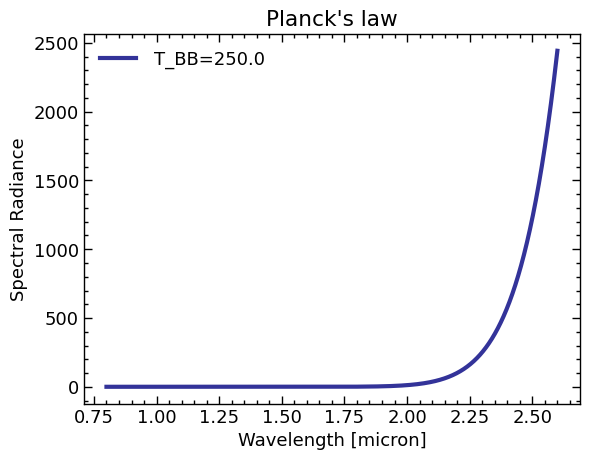

[INFO]    :: Add in OH lines
[INFO]    :: Reading in the Rousselot (2000) OH line list
[INFO]    :: Selecting stronger OH lines
[INFO]    :: Creating line spectrum
[INFO]    :: Plot of the line spectrum.
[INFO]    :: Close the Figure to continue.


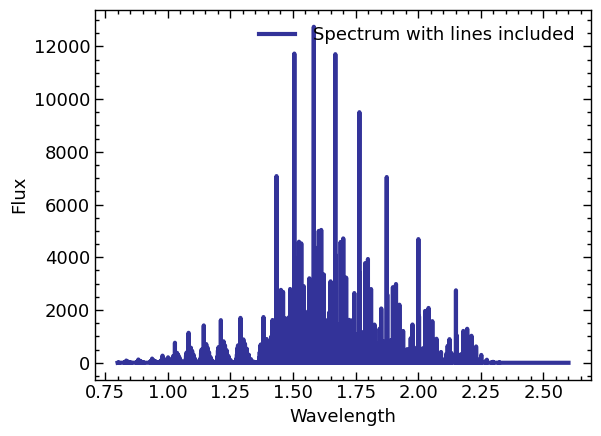

[INFO]    :: Add in H2O lines
[INFO]    :: Reading in the water atmsopheric spectrum
[INFO]    :: The binning of the wavelength array at 2.39722303825895 is: 5.7467013441225845e-06
[INFO]    :: Covolving with a Gaussian kernel with sigma = 3.542655315943133 pixels
[INFO]    :: Spectrum Convolved at R = 50000.0
[INFO]    :: Close the Figure to continue.


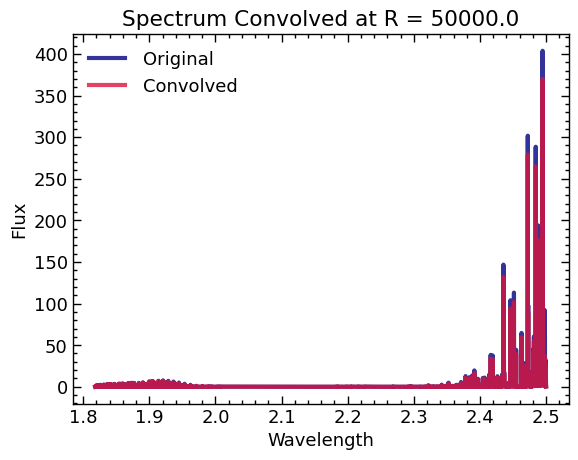

[INFO]    :: Plot of the sky emission at R=50000.0
[INFO]    :: Close the Figure to continue.


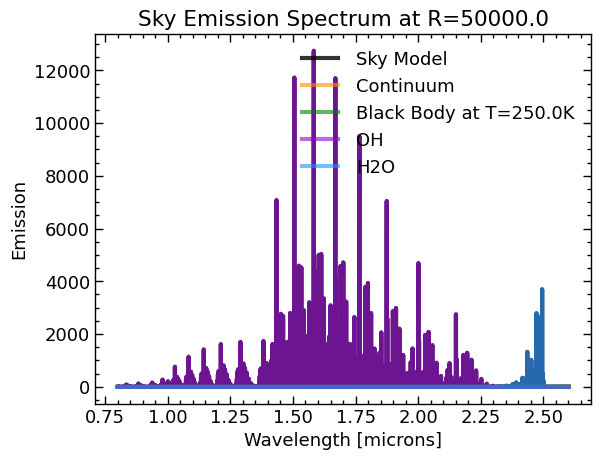

In [2]:
wave_model, flux_model = wavemodel.nearIR_modelsky(50000.0, dlam = 1.0, debug=True)

In [3]:
from scipy import interpolate

dir_name = '../MakeWavelengthGrids/nonlinear_cals_j/Nonlin-calib_1D/TXT/'
wvs = []
fs = []

order_min = 55
order_max = 67
norders = order_max-order_min + 1
for ii in range(order_min,order_max+1):
    #hdu = fits.open(dir_name+'n3_arcs_ord'+str(ii)+'.wv.nonlin.fits')
    dats = np.genfromtxt(dir_name+'n3_arcs_ord'+str(ii)+'.wv.nonlin.txt')
    #print(np.shape(dats))
    fs.append(np.flip(dats[:,1]))
    wvs.append(np.flip(dats[:,0]))
wvs = np.array(wvs)
fs = np.array(fs)

fs_model_int = np.copy(fs)
for iord, xord in enumerate(range(order_min,order_max+1)):
    fs_model_int[iord, :] = interpolate.interp1d(wave_model, flux_model, kind='cubic')(wvs[iord,:])



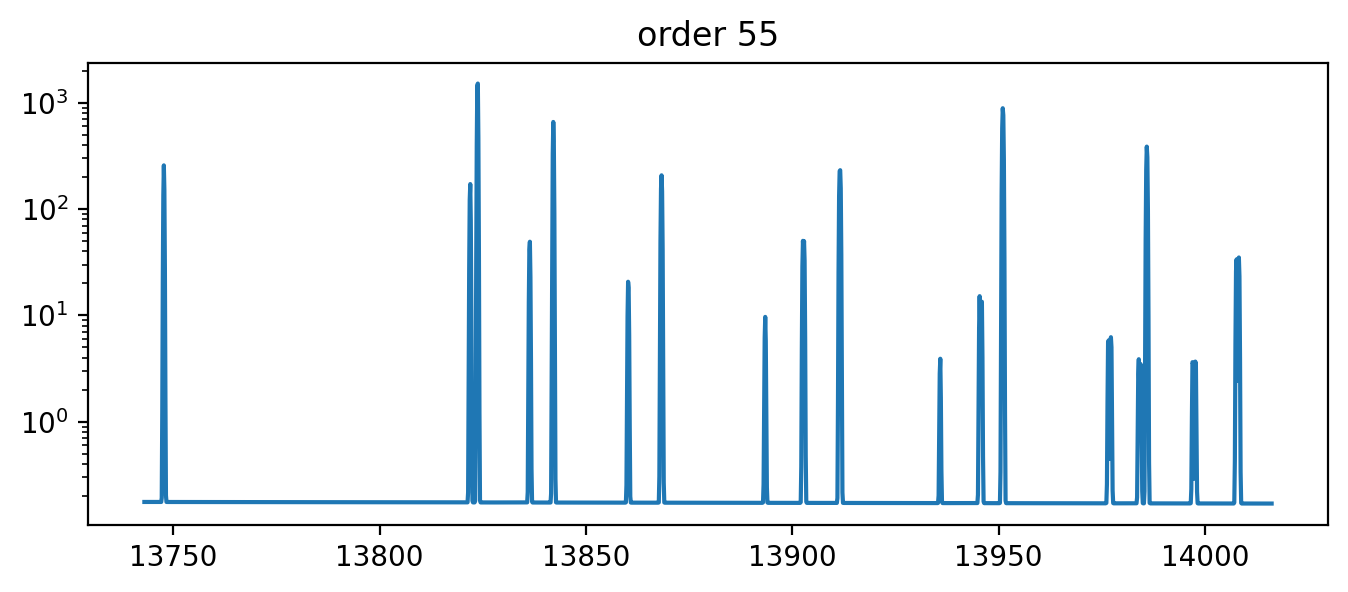

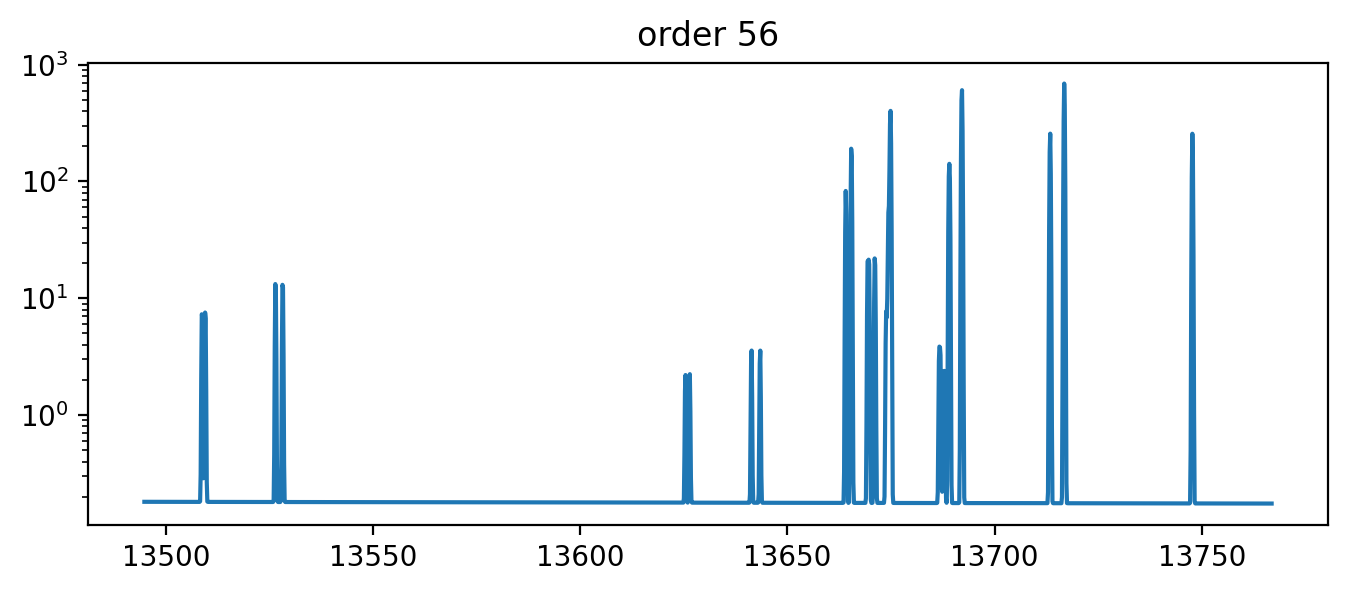

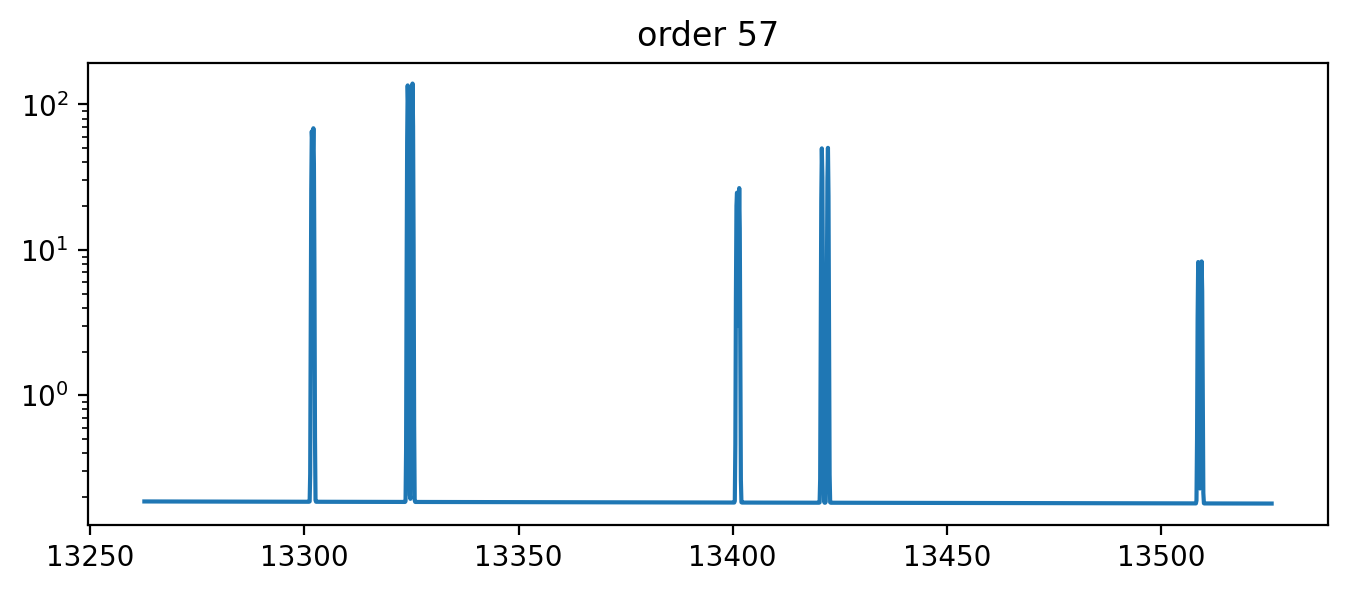

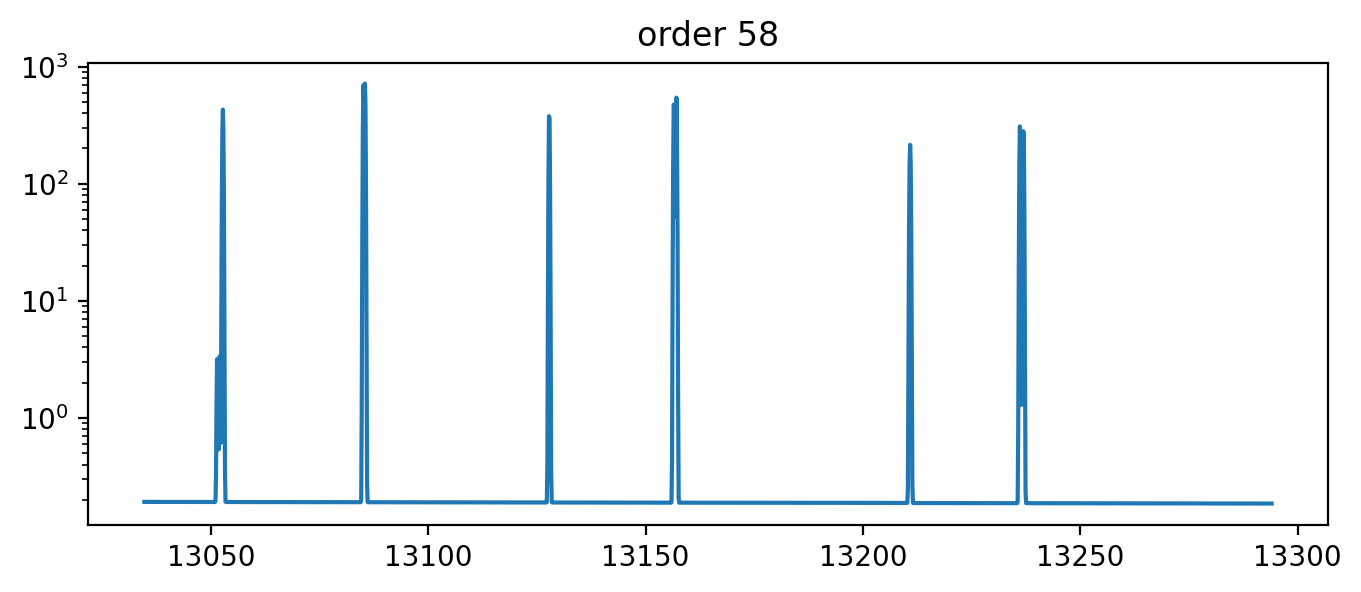

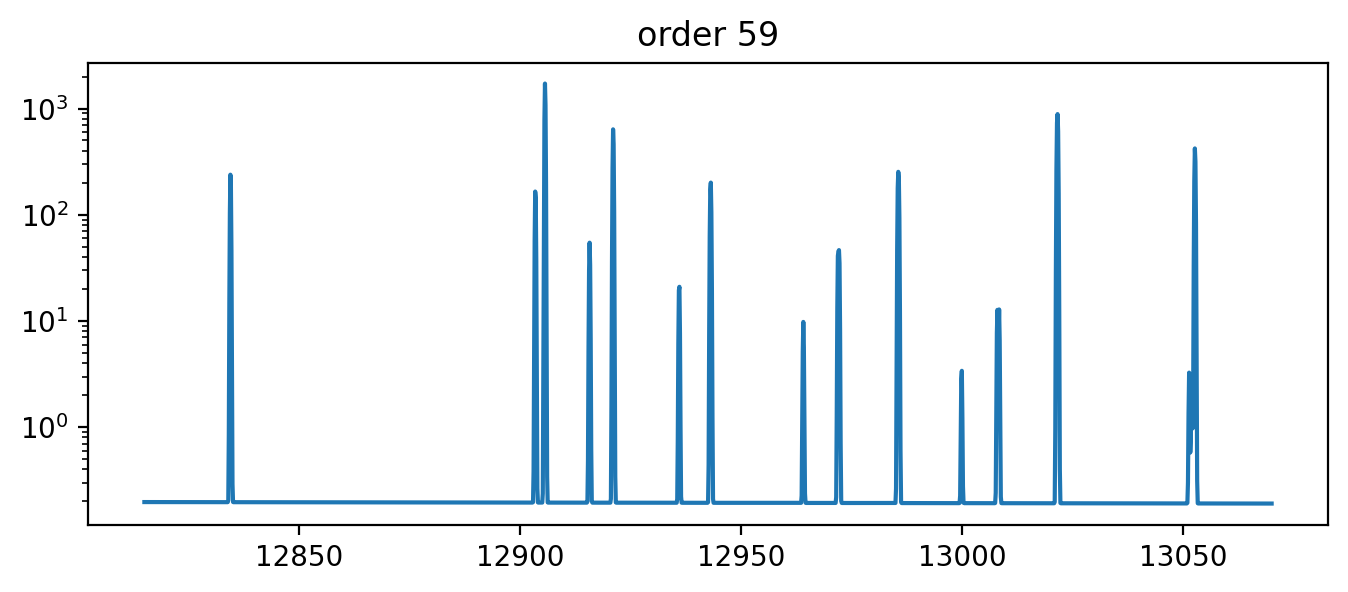

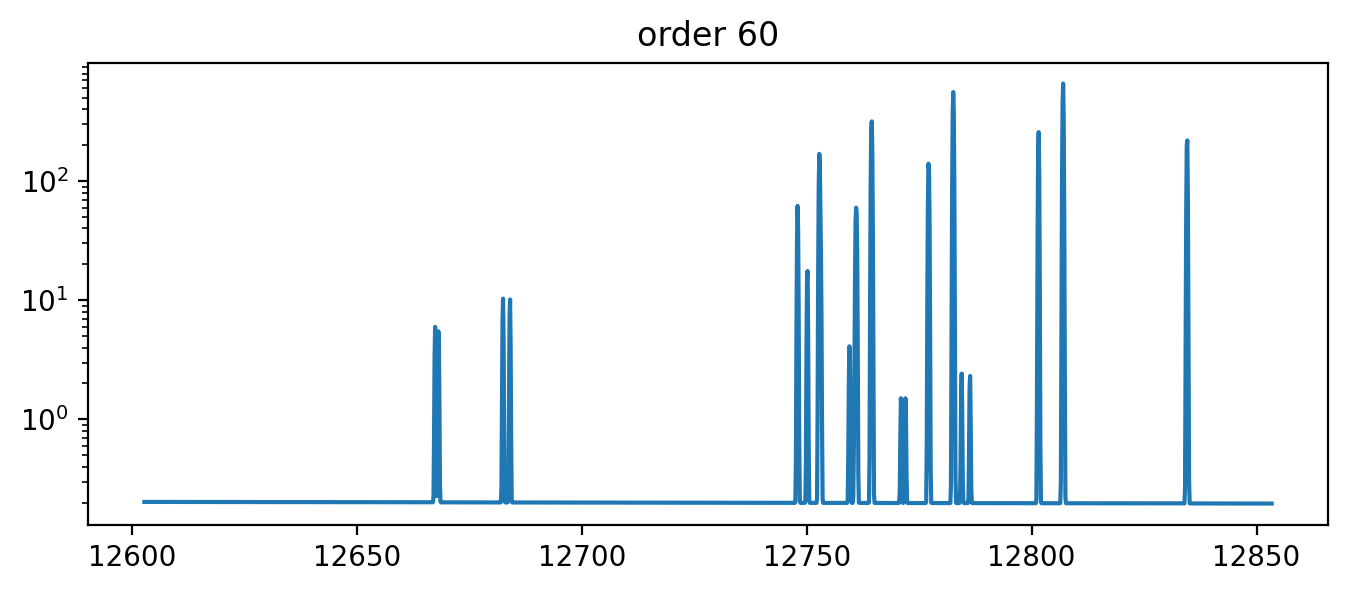

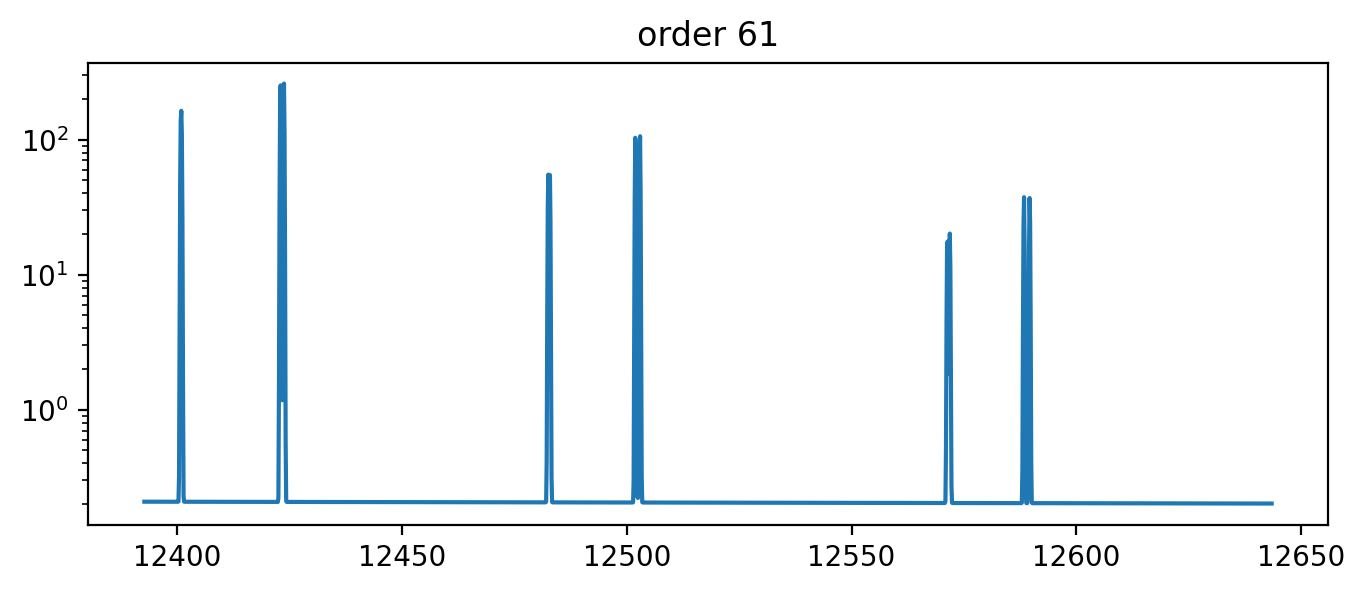

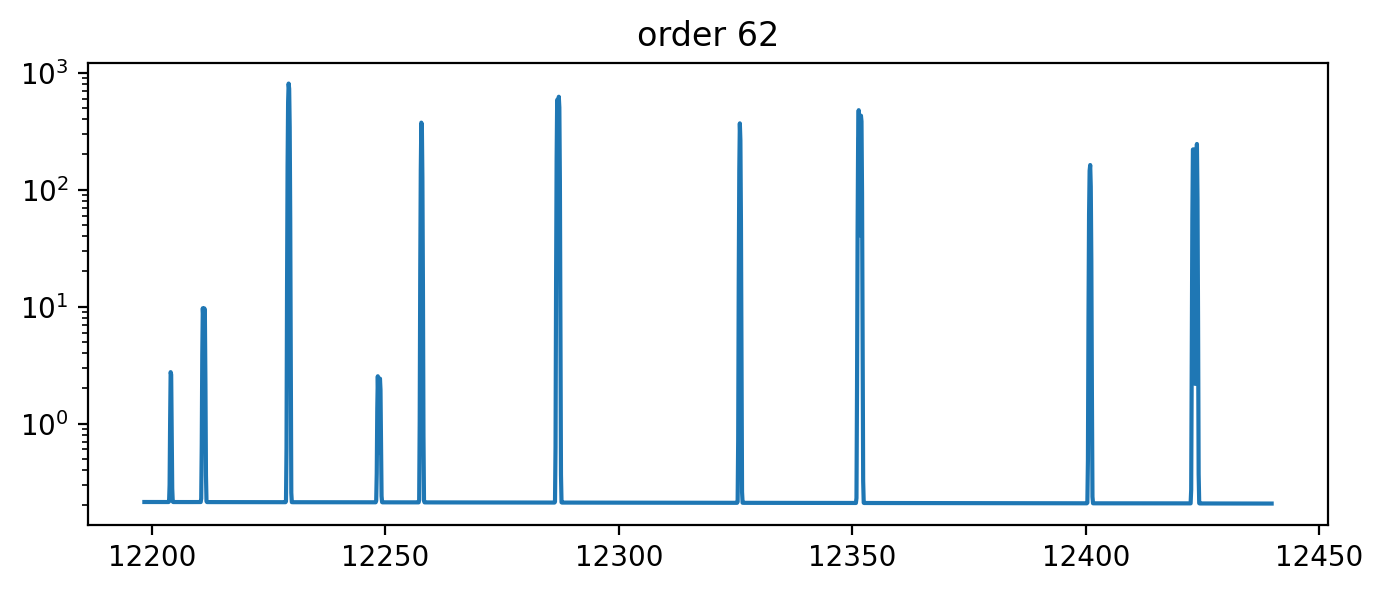

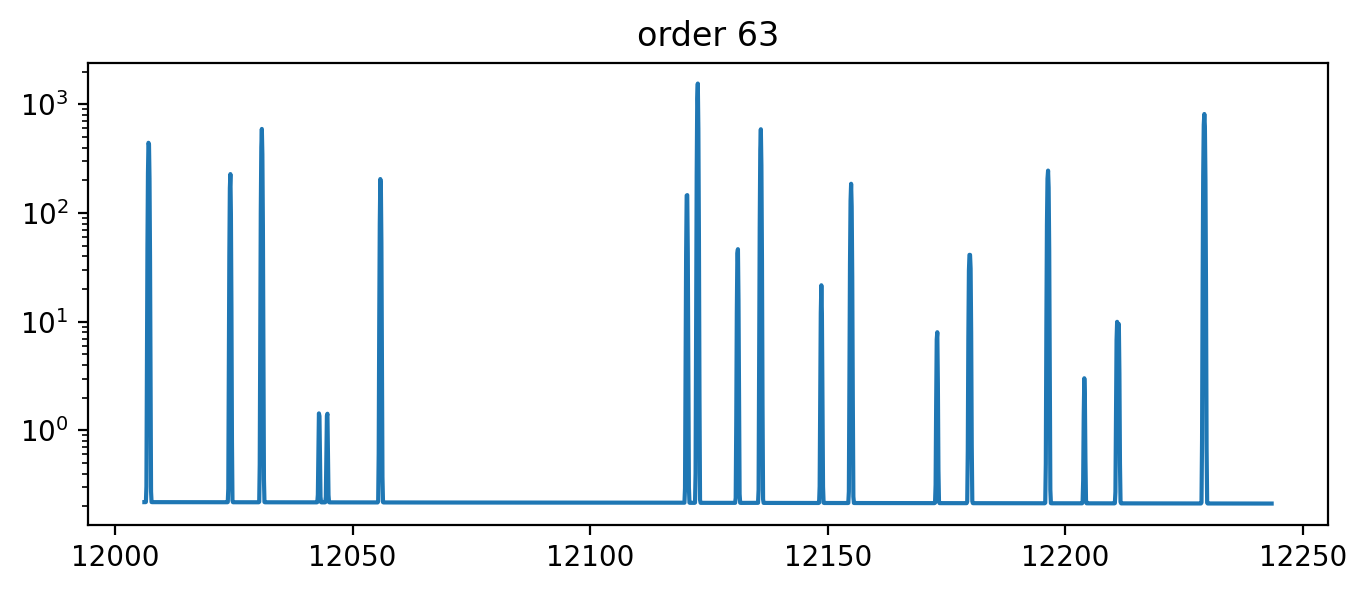

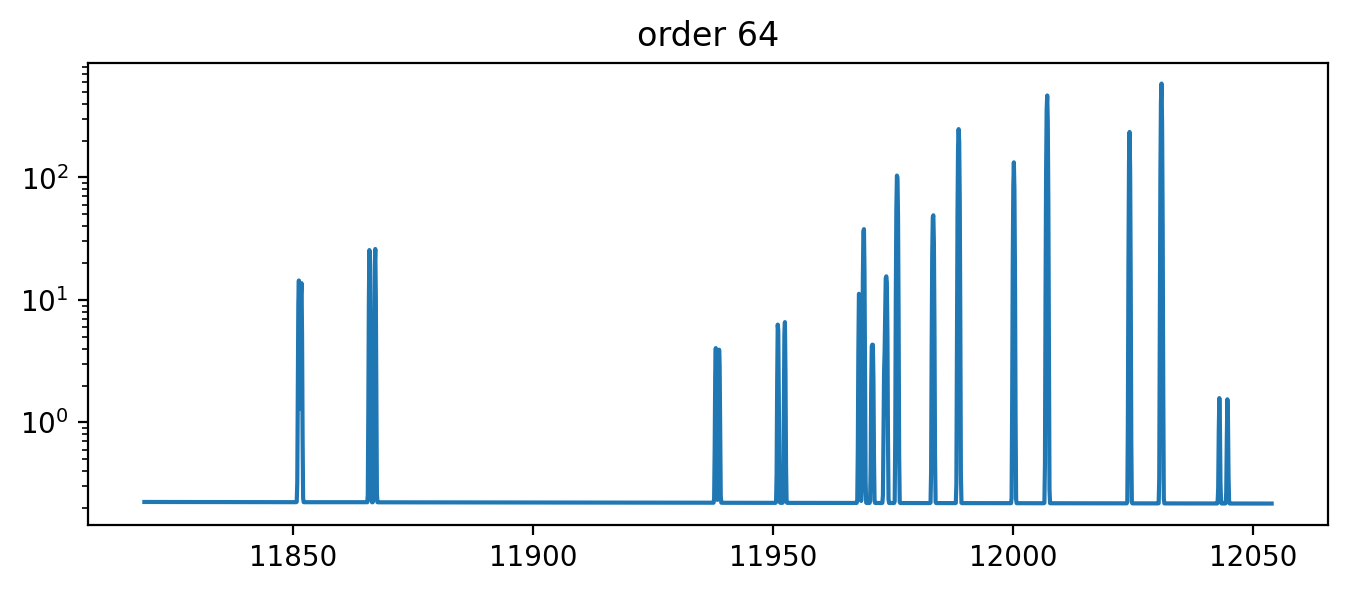

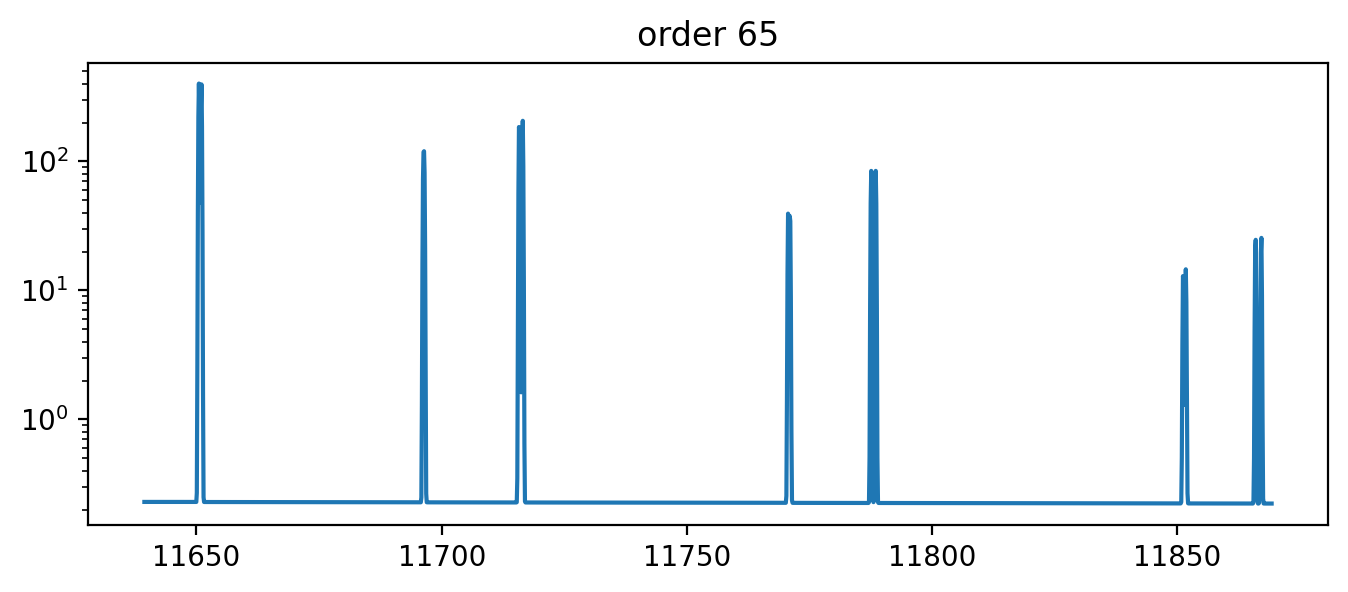

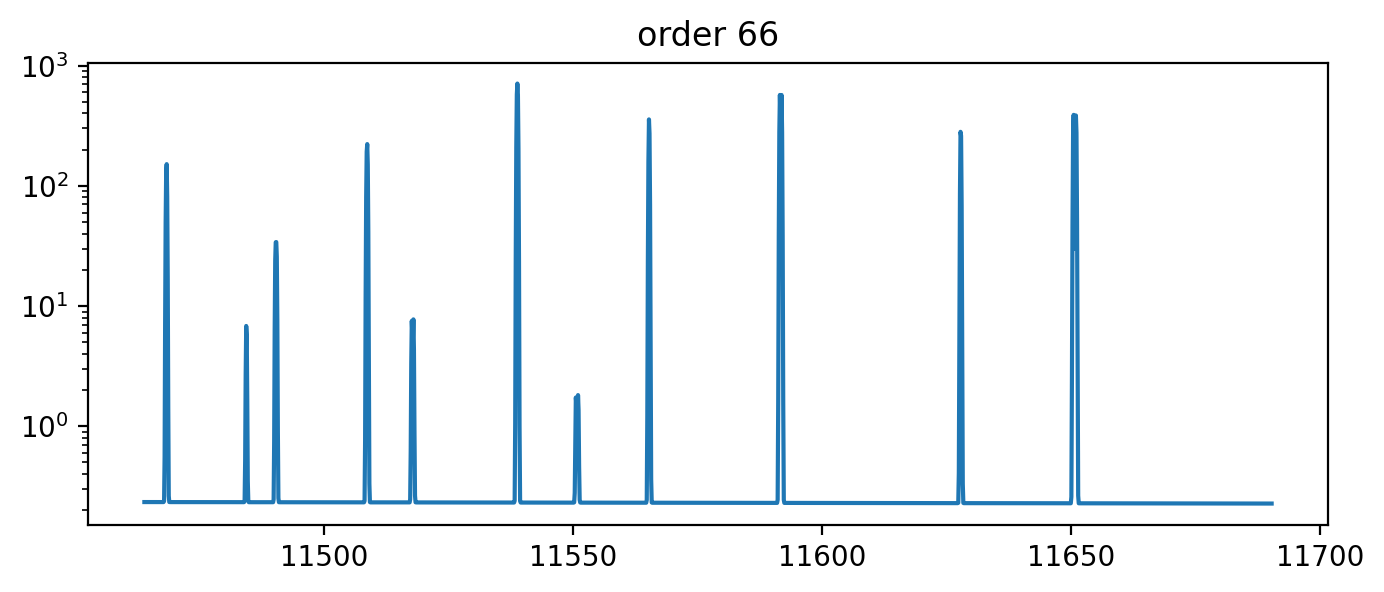

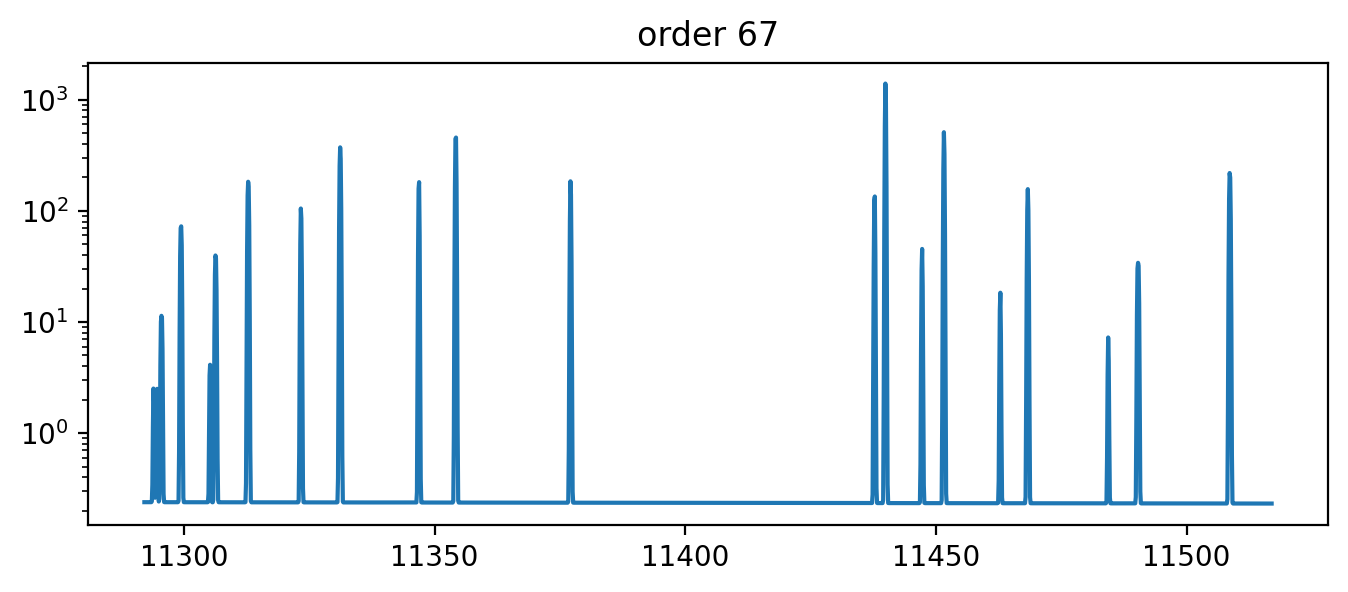

In [4]:
dwave_pix = np.zeros(norders)
dloglam_pix = np.zeros(norders)
for iord, ordnum in enumerate(range(order_min,order_max+1)):
    indsneg = np.where(fs[iord,:] < 0)[0]
    fs[iord,indsneg] = np.nanmedian(fs[iord,:])
    plt.figure(figsize=(8,3), dpi=200)
    plt.semilogy(wvs[iord,:], fs_model_int[iord,:])
    plt.title('order '+str(ordnum))
    plt.show()
    this_wave = wvs[iord,:]
    this_dwave = this_wave[1:]-this_wave[0:-1]
    dwave_pix[iord] = np.median(this_dwave.min())
    dloglam_pix[iord] = np.median((this_dwave/this_wave[0:len(this_dwave)]/np.log(10.0)).min())
dloglam_pix_final = np.min(dloglam_pix)
c_kms = 2.9979e5
dv_pix_final = np.log(10.0)*c_kms*dloglam_pix_final


In [5]:
gpm_composite = np.ones(np.shape(wvs))

In [6]:
params=Table([['random.fits'], [order_min],[order_max],[order_max-order_min+1],
                  [wvs.min()], [wvs[gpm_composite > 0.0].max()],
                  [dloglam_pix_final], [dv_pix_final]],
                  names=('arxiv_file','order_min', 'order_max', 'norders','wave_min','wave_max','dloglam','dv'))

In [7]:
hdulist = fits.HDUList()
hdulist.append(fits.BinTableHDU(params.as_array()))  # hdu = 1
hdulist.append(fits.ImageHDU(np.array(wvs).T))  # hdu = 2
hdulist.append(fits.ImageHDU(np.array(fs_model_int).T))  # hdu = 3
hdulist.append(fits.ImageHDU(np.array(gpm_composite.astype(float)).T))  # hdu = 3
hdulist.writeto('keck_nirspec_j_composite_OH.fits', overwrite=True)

print(np.shape(fits.open('keck_nirspec_j_composite_OH.fits')[2].data))
print(fits.open('keck_nirspec_j_composite_OH.fits')[2].data[[0, -1], :])

(2048, 13)
[[13743.03870077 13494.81213565 13262.61430768 13034.67837977
  12815.07317712 12602.70065355 12392.68533887 12198.3715998
  12006.16441609 11819.00522416 11639.37292733 11463.87505802
  11292.13337428]
 [14016.11826178 13766.88229488 13525.85925348 13294.00985091
  13070.08186322 12853.36620501 12643.4337801  12439.76306404
  12243.46812088 12053.84782403 11869.20645102 11690.28361798
  11516.95343786]]


In [8]:
fixed_format=Table([np.flip(wvs, axis=0), np.flip(fs_model_int, axis=0),np.arange(order_max, order_min-1, -1)],
                  names=('wave','flux', 'order'))
hdulist = fits.HDUList()
hdulist.append(fits.BinTableHDU(fixed_format))  # hdu = 1
hdulist.writeto('keck_nirspec_j_fixed_OH.fits', overwrite=True)
print(fixed_format['order'].value)
print(norders)
print(order_min)

[67 66 65 64 63 62 61 60 59 58 57 56 55]
13
55


# Make Echelle Angles file

In [9]:
from pypeit.core.fitting import robust_fit


obsmode = 'Spectroscopy'

polyorder = 2

xd_angle_fit_params = Table([[ 33.0 ],[36.0], [ obsmode], [ polyorder ], [ 'legendre' ]]
                ,names=('xd_xmin','xd_xmax','xdisp_vec', 'xd_polyorder', 'xd_func'))

xd_angle_fit_coeffs = np.zeros((1, polyorder + 1))

#since J Band is essentially fixed format, the default coeffs are just the reddest order vals, others are 0
xd_angle_fit_coeffs[:,0] = order_min


ech_min =60.0
ech_max = 66.0
n_final = 4
coeff_fit_order_min = 1
coeff_fit_order_max = 2
nmax = 3  # np.copy(n_final)
coeff_fit_order_vec = np.full(n_final+1, coeff_fit_order_min)
coeff_fit_order_vec[0:nmax] = coeff_fit_order_max

ech_angle_fit_params=Table([
        [ech_min],[ech_max],[norders], [order_min], [order_max], [int(n_final)],[coeff_fit_order_vec], [ 'legendre' ],[ 'legendre' ],
        [0.0], [1.0]],
        names=('ech_xmin','ech_xmax','norders','order_min', 'order_max', 'ech_n_final','ech_coeff_fit_order', 'ech_func',
               'wave_func',
               'wave_xmin', 'wave_xmax'))

ech_angle_fit_coeffs = np.zeros((norders, n_final + 1, coeff_fit_order_max + 1))
print(np.shape(wvs))
for iord, xord in enumerate(range(order_min, order_max + 1)):
    min_wav_order = np.flip(wvs, axis=0)[iord,0]
    max_wav_order = np.flip(wvs, axis=0)[iord, -1]
    print(min_wav_order, max_wav_order)
    xarray = np.arange(2048.0)
    y_intercept = 0.5*(min_wav_order + max_wav_order)
    slopeval = 0.5*(max_wav_order - min_wav_order)#/np.max(xarray)
    pypeitFit = robust_fit(xarray, np.flip(wvs, axis=0)[iord,:], n_final,
                                       function='legendre', minx=0, maxx=2048, maxiter=25,
                                       lower=1e10, upper=1.0e10, maxrej = 0, sticky=True, use_mad=True,
                                       weights=None)

    wav_coeffs_vec_temp = pypeitFit.fitc
    print(np.arange(order_max, order_min-1, -1)[iord], min_wav_order, max_wav_order, wav_coeffs_vec_temp)
    
    #wav_coeffs_vec_temp[0] = y_intercept
    #wav_coeffs_vec_temp[1] = slopeval
    ech_coeffs_temp = np.zeros((coeff_fit_order_max+1))
    for ii in range(n_final + 1):
        ech_coeffs_temp[0] = wav_coeffs_vec_temp[ii]
        ech_angle_fit_coeffs[iord, ii, :] = ech_coeffs_temp



fit_params = table.hstack((ech_angle_fit_params, xd_angle_fit_params))
hdulist = fits.HDUList()
hdulist.append(fits.BinTableHDU(fit_params.as_array()))  # hdu = 1
hdulist.append(fits.ImageHDU(np.flip(ech_angle_fit_coeffs, axis=0)))  # hdu = 2
hdulist.append(fits.ImageHDU(np.array(xd_angle_fit_coeffs)))  # hdu = 3
hdulist.writeto('keck_nirspec_j_OH_angle_fits.fits', overwrite=True)

print(np.shape(np.array(ech_angle_fit_coeffs)))

(13, 2048)
11292.1333742819 11516.9534378578
67 11292.1333742819 11516.9534378578 [ 1.14034170e+04  1.12466679e+02  1.18304017e+00  2.27177251e-10
 -5.24526849e-12]
11463.875058021 11690.2836179849
66 11463.875058021 11690.2836179849 [ 1.15753370e+04  1.13525738e+02  1.79961394e+00 -2.64163914e-01
 -3.79068636e-12]
11639.3729273295 11869.2064510217
65 11639.3729273295 11869.2064510217 [ 1.17523640e+04  1.15431480e+02  1.98357417e+00 -4.56787777e-01
 -3.26037180e-12]
11819.0052241625 12053.8478240281
64 11819.0052241625 12053.8478240281 [ 1.19346952e+04  1.17481287e+02  1.79127694e+00  2.34063021e-10
 -8.63982336e-12]
12006.1644160937 12243.468120876
63 12006.1644160937 12243.468120876 [ 1.21230142e+04  1.19200098e+02  1.86158636e+00 -4.88747411e-01
 -5.62520852e-12]
12198.371599798 12439.7630640357
62 12198.371599798 12439.7630640357 [ 1.23172533e+04  1.20757442e+02  1.87569762e+00  2.46585020e-10
 -3.73940358e-12]
12392.6853388724 12643.4337801037
61 12392.6853388724 12643.4337801037 

In [ ]:
wavemodel.create_OHlinelist(50000.0, dlam = 1.0)

[INFO]    :: Creating wavelength vector in velocity space.
[INFO]    :: Add in a blackbody for the atmosphere.
[INFO]    :: Creating BB spectrum at T=250.0K
[INFO]    :: Add in OH lines
[INFO]    :: Reading in the Rousselot (2000) OH line list
[INFO]    :: Selecting stronger OH lines
[INFO]    :: Creating line spectrum
[INFO]    :: Add in H2O lines
[INFO]    :: Reading in the water atmsopheric spectrum
[INFO]    :: The binning of the wavelength array at 2.39722303825895 is: 5.7467013441225845e-06
[INFO]    :: Covolving with a Gaussian kernel with sigma = 3.542655315943133 pixels
[WARNING] :: No min FWHM for the line detection set. Derived from the resolution at the center of the spectrum
[WARNING] :: No file_root_name as been set. The file will called OH_SKY_lines.dat
[INFO]    :: Searching for peaks 3.0 sigma above background
[INFO]    :: Printing file: OH_SKY_lines.dat
